<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/240625_KARI_SDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 42.8 MB/s eta 0:00:00


In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

<ipython-input-6-e7ed24c77dbd>:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


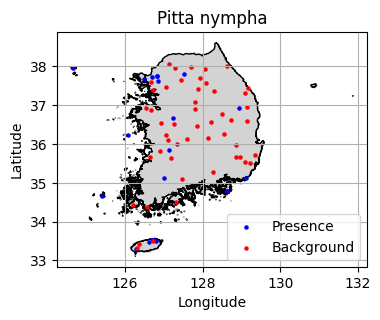

In [6]:
# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

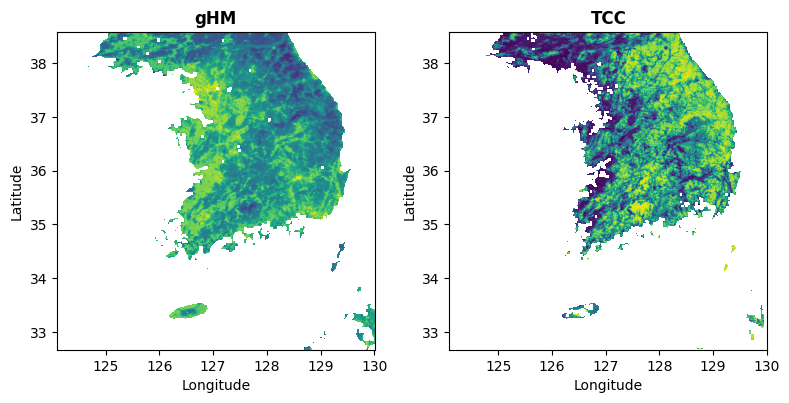

In [21]:
# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# gHM 플롯
show(ghm, ax=ax1, title='gHM')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# TCC 플롯
show(tcc, ax=ax2, title='TCC')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [30]:
# 통합 데이터 생성 및 presence 필드 추가
gdf['presence'] = 1
rand_gdf['presence'] = 0
combined_gdf = pd.concat([gdf, rand_gdf])

# 좌표에 대한 픽셀 값을 샘플링하여 새 필드 추가
def sample_raster(raster, points_gdf):
    values = []
    for geom in points_gdf.geometry:
        if geom.geom_type == 'Point':
            point = geom
            try:
                for val in raster.sample([(point.x, point.y)]):
                    values.append(val[0])
            except ValueError:
                values.append(None)
        else:
            values.append(None)
    return values

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

,decimalLatitude,decimalLongitude,species,geometry,presence,ghm_value,tcc_value
0,33.516865,126.7171,Pitta nympha,POINT (126.71710 33.51687),1,0.612164,61.037022


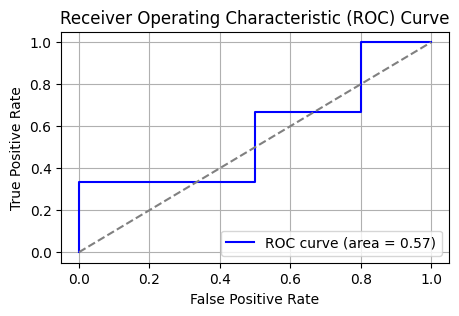

In [37]:
# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']]
y_train = train_gdf['presence']
X_test = test_gdf[['ghm_value', 'tcc_value']]
y_test = test_gdf['presence']

# Logistic Regression 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


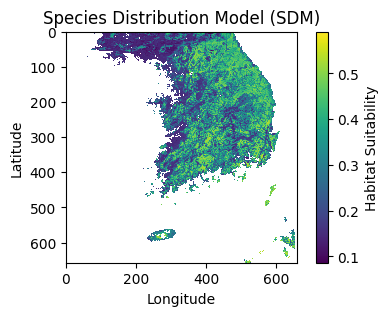

In [41]:
# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
sdm_valid = model.predict_proba(X_valid)[:, 1]

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<ipython-input-43-f0db3cb4fd7f>:53: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


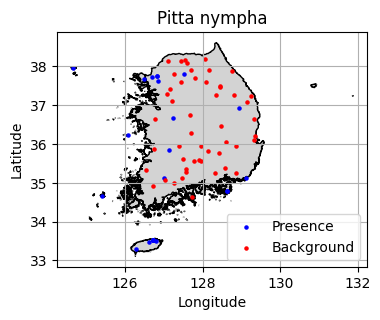

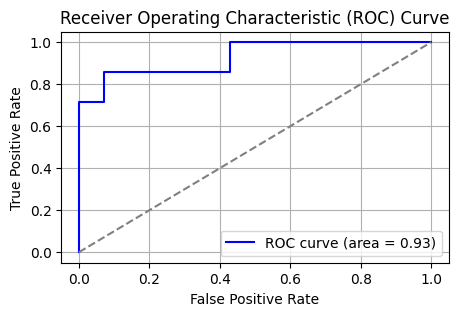

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


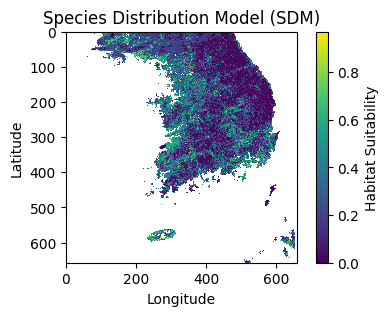

In [43]:
# -*- coding: utf-8 -*-
"""240625_KARI_SDM.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/240625_KARI_SDM.ipynb
"""

!pip install rasterio

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

# 좌표에 따라 ghm와 tcc 값을 추출하는 함수
def sample_raster(raster, gdf):
    values = []
    for geom in gdf.geometry:
        for val in raster.sample([(geom.x, geom.y)]):
            if val is not None:
                values.append(val[0])
            else:
                values.append(None)
    return values

combined_gdf = gpd.GeoDataFrame(pd.concat([gdf, rand_gdf], ignore_index=True))
combined_gdf['presence'] = [1] * len(gdf) + [0] * len(rand_gdf)

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']]
y_train = train_gdf['presence']
X_test = test_gdf[['ghm_value', 'tcc_value']]
y_test = test_gdf['presence']

# Random Forest 모델 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
sdm_valid = model.predict_proba(X_valid)[:, 1]

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<ipython-input-44-813d63c010b6>:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


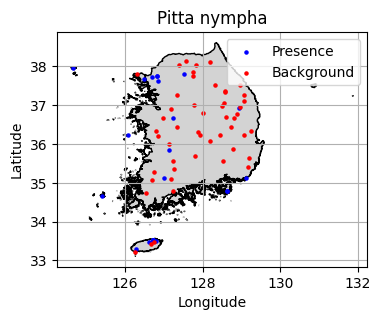

Epoch 1/50, Loss: 4.042338848114014
Epoch 2/50, Loss: 2.814492702484131
Epoch 3/50, Loss: 1.4328974485397339
Epoch 4/50, Loss: 0.7150497436523438
Epoch 5/50, Loss: 0.3828047513961792
Epoch 6/50, Loss: 0.39009082317352295
Epoch 7/50, Loss: 0.32320475578308105
Epoch 8/50, Loss: 0.9911928772926331
Epoch 9/50, Loss: 1.3187508583068848
Epoch 10/50, Loss: 0.6999473571777344
Epoch 11/50, Loss: 0.8555808067321777
Epoch 12/50, Loss: 1.2035595178604126
Epoch 13/50, Loss: 0.7141914963722229
Epoch 14/50, Loss: 0.6357114911079407
Epoch 15/50, Loss: 0.3827275037765503
Epoch 16/50, Loss: 0.5063132643699646
Epoch 17/50, Loss: 0.5861032009124756
Epoch 18/50, Loss: 0.6379040479660034
Epoch 19/50, Loss: 0.6221473813056946
Epoch 20/50, Loss: 0.6068360209465027
Epoch 21/50, Loss: 0.6192520260810852
Epoch 22/50, Loss: 0.539216160774231
Epoch 23/50, Loss: 0.6725846529006958
Epoch 24/50, Loss: 0.7254008054733276
Epoch 25/50, Loss: 0.584238588809967
Epoch 26/50, Loss: 0.739778459072113
Epoch 27/50, Loss: 0.490

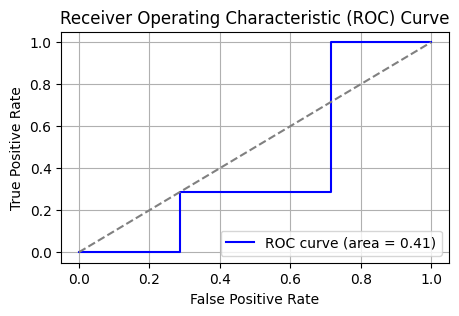

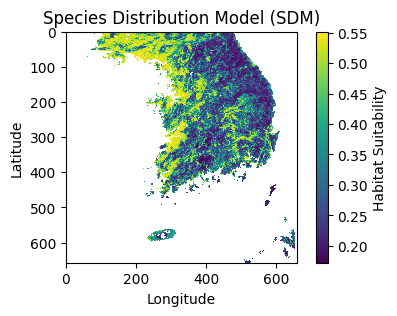

In [44]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

# 좌표에 따라 ghm와 tcc 값을 추출하는 함수
def sample_raster(raster, gdf):
    values = []
    for geom in gdf.geometry:
        for val in raster.sample([(geom.x, geom.y)]):
            if val is not None:
                values.append(val[0])
            else:
                values.append(None)
    return values

combined_gdf = gpd.GeoDataFrame(pd.concat([gdf, rand_gdf], ignore_index=True))
combined_gdf['presence'] = [1] * len(gdf) + [0] * len(rand_gdf)

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']].values
y_train = train_gdf['presence'].values
X_test = test_gdf[['ghm_value', 'tcc_value']].values
y_test = test_gdf['presence'].values

# PyTorch 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 평가 및 ROC 커브 그리기
model.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze().numpy()
        y_pred_prob.extend(y_pred)
        y_true.extend(y_batch.numpy())

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
with torch.no_grad():
    sdm_valid = model(X_valid_tensor).squeeze().numpy()

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<ipython-input-45-596a4b61a0a8>:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


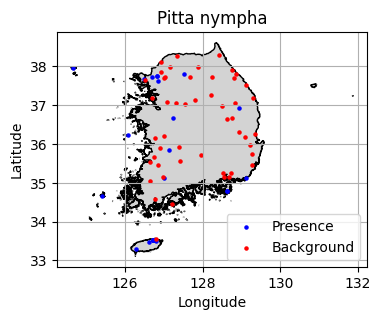

Epoch 1/50, Loss: 0.6167898178100586
Epoch 2/50, Loss: 0.6998915672302246
Epoch 3/50, Loss: 0.7108131051063538
Epoch 4/50, Loss: 0.6800841689109802
Epoch 5/50, Loss: 0.6765885353088379
Epoch 6/50, Loss: 0.6966013312339783
Epoch 7/50, Loss: 0.6691495776176453
Epoch 8/50, Loss: 0.5968950986862183
Epoch 9/50, Loss: 0.7308192253112793
Epoch 10/50, Loss: 0.6369781494140625
Epoch 11/50, Loss: 0.737177848815918
Epoch 12/50, Loss: 0.6512239575386047
Epoch 13/50, Loss: 0.6032441854476929
Epoch 14/50, Loss: 0.7017163038253784
Epoch 15/50, Loss: 0.6081839203834534
Epoch 16/50, Loss: 0.6525142788887024
Epoch 17/50, Loss: 0.6468547582626343
Epoch 18/50, Loss: 0.5796328783035278
Epoch 19/50, Loss: 0.6289348602294922
Epoch 20/50, Loss: 0.6027703881263733
Epoch 21/50, Loss: 0.5718451738357544
Epoch 22/50, Loss: 0.564315676689148
Epoch 23/50, Loss: 0.6540666818618774
Epoch 24/50, Loss: 0.7044355273246765
Epoch 25/50, Loss: 0.639533519744873
Epoch 26/50, Loss: 0.6786385774612427
Epoch 27/50, Loss: 0.575

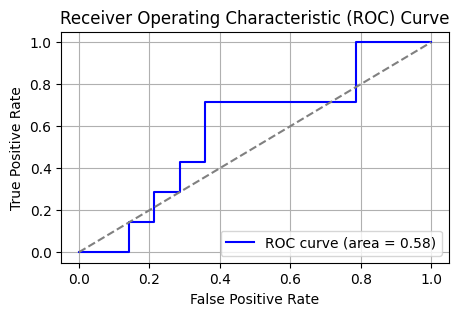

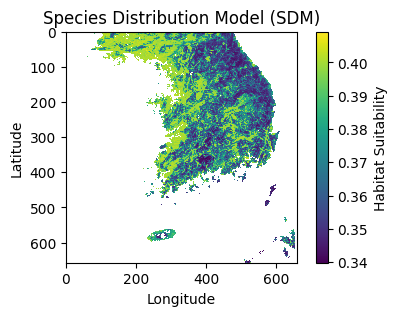

In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

# 좌표에 따라 ghm와 tcc 값을 추출하는 함수
def sample_raster(raster, gdf):
    values = []
    for geom in gdf.geometry:
        for val in raster.sample([(geom.x, geom.y)]):
            if val is not None:
                values.append(val[0])
            else:
                values.append(None)
    return values

combined_gdf = gpd.GeoDataFrame(pd.concat([gdf, rand_gdf], ignore_index=True))
combined_gdf['presence'] = [1] * len(gdf) + [0] * len(rand_gdf)

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']].values
y_train = train_gdf['presence'].values
X_test = test_gdf[['ghm_value', 'tcc_value']].values
y_test = test_gdf['presence'].values

# PyTorch 데이터셋 및 데이터로더 생성
X_train = X_train[:, np.newaxis, :]  # CNN 입력 형식에 맞게 변형
X_test = X_test[:, np.newaxis, :]    # CNN 입력 형식에 맞게 변형
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16 * 1, 32)  # 입력 채널 크기에 맞게 조정
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 평가 및 ROC 커브 그리기
model.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze().numpy()
        y_pred_prob.extend(y_pred)
        y_true.extend(y_batch.numpy())

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
X_valid = X_valid[:, np.newaxis, :]  # CNN 입력 형식에 맞게 변형
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
with torch.no_grad():
    sdm_valid = model(X_valid_tensor).squeeze().numpy()

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<ipython-input-47-511e642c6873>:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


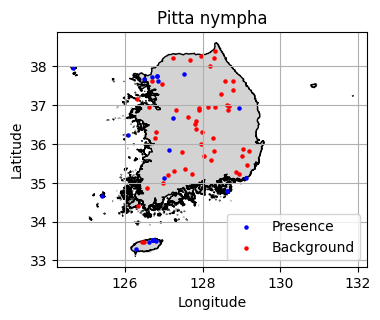

Epoch 0/10000, D Loss: 0.9306864738464355, G Loss: 0.577403724193573
Epoch 1000/10000, D Loss: 0.005613953806459904, G Loss: 5.221595287322998
Epoch 2000/10000, D Loss: 0.000975926173850894, G Loss: 7.769082069396973
Epoch 3000/10000, D Loss: 0.00023850555589888245, G Loss: 9.157770156860352
Epoch 4000/10000, D Loss: 3.277456562500447e-05, G Loss: 10.33088493347168
Epoch 5000/10000, D Loss: 9.573394891049247e-06, G Loss: 11.558098793029785
Epoch 6000/10000, D Loss: 3.172424840158783e-06, G Loss: 12.661859512329102
Epoch 7000/10000, D Loss: 2.6437560336489696e-06, G Loss: 13.781862258911133
Epoch 8000/10000, D Loss: 3.491930158361356e-07, G Loss: 14.868081092834473
Epoch 9000/10000, D Loss: 1.1548478084932867e-07, G Loss: 15.975175857543945
Epoch 1/50, Loss: 0.6112461686134338
Epoch 2/50, Loss: 0.48857635259628296
Epoch 3/50, Loss: 0.37678056955337524
Epoch 4/50, Loss: 0.4839285910129547
Epoch 5/50, Loss: 0.1566304862499237
Epoch 6/50, Loss: 0.08373788744211197
Epoch 7/50, Loss: 0.23158

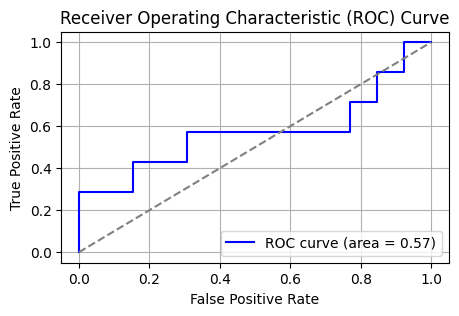

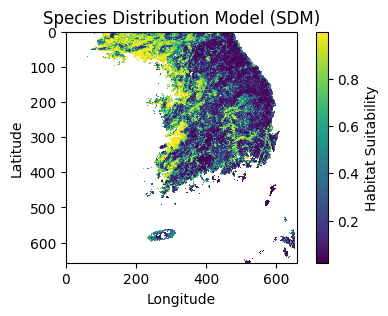

In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 출현 좌표 읽기
df = pd.read_csv('https://github.com/osgeokr/GEE-PAM-Book/raw/main/pitta_nympha.csv?raw=True')

# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# 한국 경계
kor_gdf = gpd.read_file('https://github.com/osgeokr/GEE-PAM-Book/raw/main/kor.gpkg?raw=True')

# 폴리곤 내부에서 임의 좌표 생성
num_points = len(gdf) * 2 # 좌표 개수 정의
polygon = kor_gdf.unary_union  # 단일 폴리곤으로 결합

points = []
while len(points) < num_points:
    minx, miny, maxx, maxy = polygon.bounds
    random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if polygon.contains(random_point):
        points.append(random_point)

rand_gdf = gpd.GeoDataFrame(geometry=points)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the South Korea GeoDataFrame
kor_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', label='South Korea')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')
rand_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Background')

plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

# gHM와 TCC 래스터 호출
ghm_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/ghm.tif?raw=True'
ghm = rasterio.open(ghm_file)

tcc_file = 'https://github.com/osgeokr/GEE-PAM-Book/blob/main/tcc.tif?raw=True'
tcc = rasterio.open(tcc_file)

# 좌표에 따라 ghm와 tcc 값을 추출하는 함수
def sample_raster(raster, gdf):
    values = []
    for geom in gdf.geometry:
        for val in raster.sample([(geom.x, geom.y)]):
            if val is not None:
                values.append(val[0])
            else:
                values.append(None)
    return values

combined_gdf = gpd.GeoDataFrame(pd.concat([gdf, rand_gdf], ignore_index=True))
combined_gdf['presence'] = [1] * len(gdf) + [0] * len(rand_gdf)

combined_gdf['ghm_value'] = sample_raster(ghm, combined_gdf)
combined_gdf['tcc_value'] = sample_raster(tcc, combined_gdf)

# ghm_value나 tcc_value가 없는 경우 해당 좌표를 삭제
combined_gdf = combined_gdf.dropna(subset=['ghm_value', 'tcc_value'])
combined_gdf.head(1)

# 학습 데이터와 검증 데이터 분할 (7:3 비율)
train_gdf = combined_gdf.groupby('presence', group_keys=False).apply(lambda x: x.sample(frac=0.7))
test_gdf = combined_gdf.drop(train_gdf.index)

# 특징 변수와 라벨 준비
X_train = train_gdf[['ghm_value', 'tcc_value']].values
y_train = train_gdf['presence'].values
X_test = test_gdf[['ghm_value', 'tcc_value']].values
y_test = test_gdf['presence'].values

# PyTorch 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GAN 모델 정의
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

latent_dim = 10
generator = Generator(latent_dim, 16, 2)
discriminator = Discriminator(2, 16)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

# GAN 학습
num_epochs = 10000
for epoch in range(num_epochs):
    for X_batch, _ in train_loader:
        batch_size = X_batch.size(0)

        # Real data
        real_data = X_batch
        real_labels = torch.ones(batch_size, 1)

        # Fake data
        latent_space_samples = torch.randn(batch_size, latent_dim)
        fake_data = generator(latent_space_samples)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        d_optimizer.zero_grad()
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data.detach())
        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# 학습된 GAN을 사용하여 새로운 데이터를 생성
latent_space_samples = torch.randn(1000, latent_dim)
generated_data = generator(latent_space_samples).detach().numpy()

# 생성된 데이터를 기존 데이터와 결합
generated_gdf = pd.DataFrame(generated_data, columns=['ghm_value', 'tcc_value'])
generated_gdf['presence'] = 1

combined_gdf = pd.concat([combined_gdf, generated_gdf], ignore_index=True)

# PyTorch 데이터셋 및 데이터로더 재생성
X_combined = combined_gdf[['ghm_value', 'tcc_value']].values
y_combined = combined_gdf['presence'].values
combined_dataset = TensorDataset(torch.tensor(X_combined, dtype=torch.float32), torch.tensor(y_combined, dtype=torch.float32))

train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16 * 1, 32)  # 입력 채널 크기에 맞게 조정
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 평가 및 ROC 커브 그리기
model.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(1)  # Add channel dimension
        y_pred = model(X_batch).squeeze().numpy()
        y_pred_prob.extend(y_pred)
        y_true.extend(y_batch.numpy())

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# SDM 지도 래스터 생성
ghm_array = ghm.read(1)
tcc_array = tcc.read(1)

# 두 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = ~np.isnan(ghm_array) & ~np.isnan(tcc_array)
ghm_valid = ghm_array[valid_mask]
tcc_valid = tcc_array[valid_mask]

# 모델 예측 수행
X_valid = np.column_stack((ghm_valid, tcc_valid))
X_valid = X_valid[:, np.newaxis, :]  # CNN 입력 형식에 맞게 변형
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
with torch.no_grad():
    sdm_valid = model(X_valid_tensor).squeeze().numpy()

# 예측 결과를 원래 배열 형태로 복원
sdm_map = np.full(ghm_array.shape, np.nan)
sdm_map[valid_mask] = sdm_valid

# SDM 지도 시각화
plt.figure(figsize=(5, 3))
plt.imshow(sdm_map, cmap='viridis', interpolation='none')
plt.colorbar(label='Habitat Suitability')
plt.title('Species Distribution Model (SDM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()